# Big Data Modeling and Management Assigment


## 🍺 The Beer project  🍺 

As it was shown in classes, graph databases are a natural way of navegating distinct types of data. For this first project we will be taking a graph database to analyse beer and breweries!   

_For reference the dataset used for this project has been extracted from [kaggle](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews), released by Evan Hallmark. Even though the author does not present metada on the origin of the data it is probably a collection of open data from places like [beeradvocate](https://www.beeradvocate.com/)_ 

#### Problem description

Explore the database via python neo4j connector and/or the graphical tool in the NEO4J webpage. Answer the questions. Submit the results by following the instructions

#### Connection details to the neo4j database
```
Host: rhea.isegi.unl.pt:7474  
Username: neo4j  
Password: F3cfcrnvBev57KZ8mcMk78L9wHgJVZuJ 
Connect URL : bolt://rhea.isegi.unl.pt:7687
```


#### Questions


0. __Example Question__ _How many beers does the database contain?_
1. How many different countries exist in the database?
1. Most reviews:  
    1. Which `Beer` has the most reviews?  
    1. Which `Brewery` has the most reviews for its beers?
    1. Which `Country` has the most reviews for its beers? 
1. Find the user/users that have the most shared reviews (reviews of the same beers) with the user CTJman?
1. Which Portuguese brewery has the most beers?
1. From those beers (the ones returned from the previous question), which has the most reviews?
1. On average how many different beer styles does each brewery produce?
1. Which brewery produces the strongest beers according to ABV?
1. If I typically enjoy a beer due to its aroma and appearance, which beer style should I try?
1. Using Graph Algorithms answer the questions:
    1. Which Countries are most similiar when it comes to the most produced Beer styles
    1. Which beer has the most similar reviews as the beer `Super Bock Stout`
1. If you had to pick 3 beers to recommend using only this database, which would you pick and why?


 Questions 8 to 10 are somewhat open, which means we'll also be evaluating the reasoning behind your answer. So there aren't necessarily bad results there are only wrong criteria, explanations or execution. 
 
##### Groups  

Groups should have 4 to 5 people  
You should register your group on moodle. An email will be going out to everyone with the credentials for the database to use when storing the results.


##### Submission      

Submission of the query results to be done to the group's redis database (explained on the first class, credentials sent via email).  
The following format is expected:
```
    >>> redis.set("0", "358873")
```

This result should be the anwser of the group to question 0

The code used to produce the results and respective explations should be uploaded to moodle. They should have a clear reference to the group, either on the file name or on the document itself. Preferably one Jupyter notebook per group.

Delivery date: Until the **midnight of May 2nd**

##### Evaluation   

This will be 20% of the final grade.   
Each solution will be evaluated on 2 components: correctness of results and simplicity of the solution.  
All code will go through plagiarism automated checks. Groups with the same code will undergo investigation.

**Note:**
Remember the Neo4j is a shared database and when creating in-memory graphs please use your group's prefix.  
Ex. Instead of `my-graph` as the name of your graph please use `group0-my-graph`.

##### Group 27: João Araujo Coelho Chaves (m20200627), John William Villalobos Ruiz (m20200540), Luis Lobo de Almedia (m20200666), Edgardo Arellano Juaréz (m20200749)

In [1]:
import redis
import py2neo
import numpy as np
import pandas as pd

from pprint import pprint

- Setting up the connection with Neo4J and Redis databases

In [2]:
#Neo4J
username='neo4j'
password='F3cfcrnvBev57KZ8mcMk78L9wHgJVZuJ'
host='rhea.isegi.unl.pt'
port='7474'
graph=py2neo.Graph(f'http://{username}:{password}@{host}:{port}')

#Redis
r=redis.Redis(host='rhea.isegi.unl.pt', port='6407', password='841604675h8960303529464l24011g49', decode_responses=True)

#### 0. How many beers does the database contain?

In [3]:
hw={} #dictionary to store the answers for each of the HW questions
hw['0']=graph.run('MATCH (b:Beers) RETURN count(*) AS Count').data()[0]['Count']
hw['0']

358873

#### 1. How many different countries exist in the database?

In [4]:
hw['1']=graph.run('MATCH (c:Country) RETURN count(DISTINCT c.country_digit) AS Countries').data()[0]['Countries']
hw['1']

200

### Understanding of the objects (Labels, Relationship Types):
- A: Getting Labels & Relationship Types on Python

In [5]:
labels=graph.run('CALL db.labels()').data()
pprint(labels)
print('')
pprint(graph.run('CALL db.relationshipTypes()').data()) 

[{'label': 'Breweries'},
 {'label': 'Country'},
 {'label': 'Beers'},
 {'label': 'Reviews'},
 {'label': 'Username'},
 {'label': 'Style'},
 {'label': 'TODELETE'}]

[{'relationshipType': 'FROM'},
 {'relationshipType': 'BREWED_AT'},
 {'relationshipType': 'MADE'},
 {'relationshipType': 'ABOUT'},
 {'relationshipType': 'OF_TYPE'}]


- B: Getting Labels & Relationship Types on Neo4j

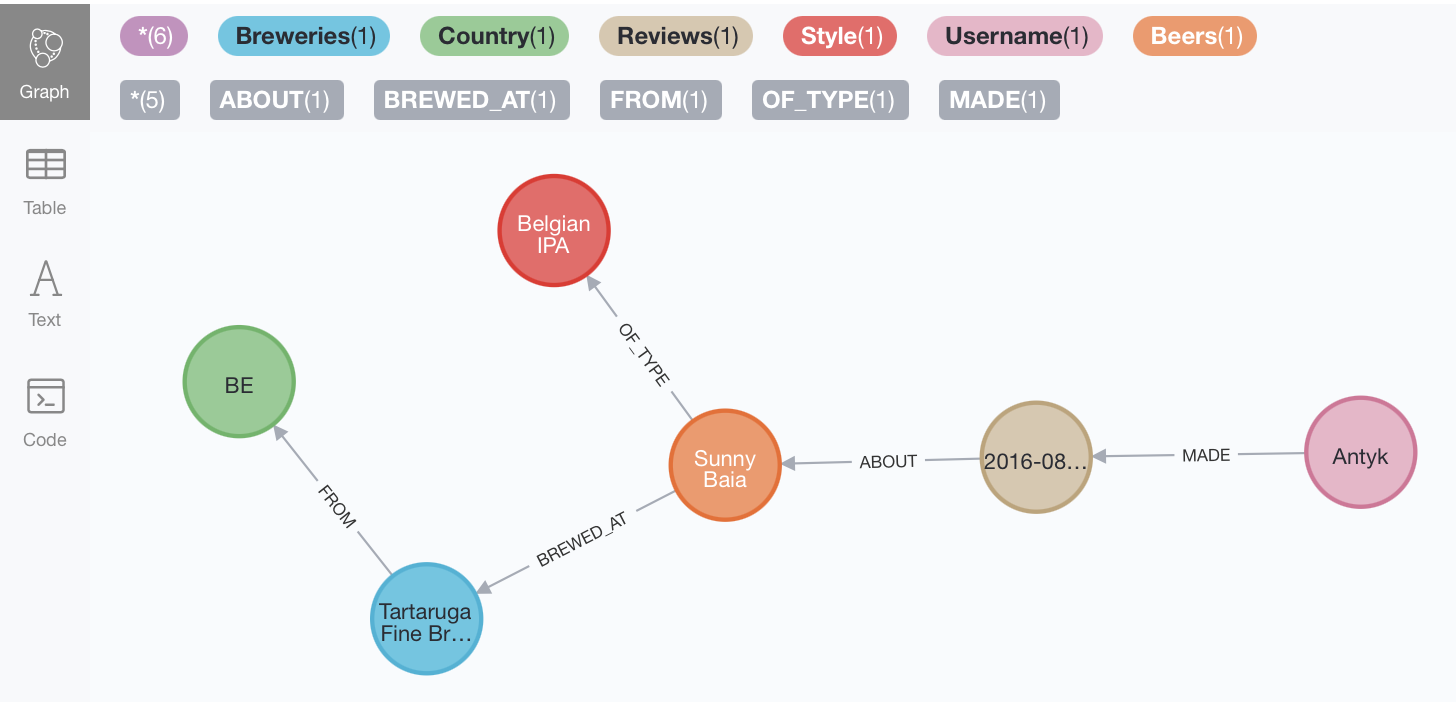

- C: Another way to visualize the labels/nodes and their relationships types

In [6]:
for i in labels:
    sName= i[list(i.keys())[0]]
    sCode= sName[0:2].lower()
    print(sName)
    pprint(graph.run(f'MATCH ({sCode}:{sName})-[r]->() RETURN type(r), count(*)').data())

Breweries
[{'count(*)': 50345, 'type(r)': 'FROM'}]
Country
[]
Beers
[{'count(*)': 358873, 'type(r)': 'BREWED_AT'},
 {'count(*)': 358873, 'type(r)': 'OF_TYPE'}]
Reviews
[{'count(*)': 9072914, 'type(r)': 'ABOUT'}]
Username
[{'count(*)': 9073128, 'type(r)': 'MADE'}]
Style
[]
TODELETE
[]


#### 2. Most reviews:

#### A: Which Beer has the most reviews?

In [7]:
hw['2A']=graph.run(
    '''
    MATCH (r:Reviews)-[a:ABOUT]->(b:Beers) 
    RETURN DISTINCT b.id, b.name, count(*) AS CountReviews 
    ORDER BY CountReviews DESC
    ''').data()[0]['b.name']
hw['2A']

'Breakfast Stout'

#### B: Which Brewery has the most reviews for its beers?

In [8]:
hw['2B']=graph.run(
    '''
    MATCH (r:Reviews)-[a:ABOUT]->(b:Beers)-[at:BREWED_AT]->(br:Breweries) 
    RETURN DISTINCT br.id, br.name, count(r) AS CountReviews 
    ORDER BY CountReviews DESC
    ''').data()[0]['br.name']
hw['2B']

'Sierra Nevada Brewing Co.'

#### C: Which Country has the most reviews for its beers?

In [9]:
hw['2C']=graph.run(
    '''
    MATCH (r:Reviews)-[a:ABOUT]->(b:Beers)-[at:BREWED_AT]->(br:Breweries)-[f:FROM]->(c:Country)
    RETURN c.country_digit as country, count(r) AS CountReviews 
    ORDER BY CountReviews DESC
    ''').data()[0]['country']
hw['2C']

'US'

#### 3. Find the user/users that have the most shared reviews (reviews of the same beers) with the user CTJman?

- 3.1 Getting the beers reviewed by user CTJman

In [10]:
beer_CTJ=graph.run(
    '''
    MATCH (u:Username)-[m:MADE]->(r:Reviews)-[a:ABOUT]->(b:Beers)
    WHERE u.user_name='CTJman'
    RETURN DISTINCT b.id,b.name
    ''').data()
beer_CTJ=[i[list(i.keys())[0]] for i in beer_CTJ]

- 3.2 Retrieve the list of User(s) with the most shared reviews from the beers on step 3.1

In [11]:
hw['3']=graph.run(f'MATCH (u:Username)-[m:MADE]->(r:Reviews)-[a:ABOUT]->(b:Beers) WHERE u.user_name<>"CTJman" AND b.id IN {beer_CTJ} RETURN u.user_name AS name, count(r) AS CountReviews ORDER BY CountReviews DESC').data()[0]['name']
hw['3']

'acurtis'

##### Below a simpler way to obtain the most shared reviews with the user CTJman

In [12]:
hw['3']=graph.run(
    '''
    MATCH (u:Username)-[m:MADE]->(r:Reviews)-[a:ABOUT]->(b:Beers)<-[a1:ABOUT]-(r1:Reviews)<-[m1:MADE]-(u1:Username)
    WHERE u.user_name="CTJman" AND u1.user_name<>u.user_name
    RETURN u1.user_name AS name, count(r1) AS CountReviews 
    ORDER BY CountReviews DESC
    ''').data()[0]['name']
hw['3']

'acurtis'

#### 4. Which Portuguese brewery has the most beers?

In [13]:
hw['4']=graph.run(
    '''
    MATCH (b:Beers)-[at:BREWED_AT]->(br:Breweries)-[f:FROM]->(c:Country)
    WHERE c.country_digit = 'PT'
    RETURN DISTINCT br.id, br.name, count(b) AS CountBeers 
    ORDER BY CountBeers DESC
    ''').data()[0]['br.name']
hw['4']

'Dois Corvos Cervejeira'

#### 5. From those beers (the ones returned from the previous question), which has the most reviews?

##### OPTION 1: Assumption that the beers from question 4 will be scanned throughout the whole set of countries & breweries

- 5.1 Get the list of beer names from question 4

In [14]:
beers=graph.run(f'MATCH (b:Beers)-[at:BREWED_AT]->(br:Breweries)-[f:FROM]->(c:Country) WHERE c.country_digit = "PT" AND br.name = "{hw["4"]}" RETURN DISTINCT b.name').data()
beers=[i[list(i.keys())[0]] for i in beers]

- 5.2 Get the most reviewed beer by passing the list of beers as parameter

In [15]:
hw['5']=graph.run(f'MATCH (r:Reviews)-[a:ABOUT]->(b:Beers) WHERE b.name in {beers} RETURN b.name, count(r) as CountReviews ORDER BY CountReviews DESC').data()[0]['b.name']
hw['5']

'Saison'

##### OPTION 2: Below a simpler way to obtain the beer with the most number of reviews, some assumptions:
- The analysis has to be straiten to the brewery: 'Dois Corvos Cervejaria' and country:'PT', otherwise the output from question 4 will be scanned throughtout the whole list of countries & breweries as those beers are being offered in different markets (breweries/countries) the output will be different

##### OBS: We decided to keep this as our final answer, however we thought it could be interesting to point out another way to do the things in option 1

In [16]:
hw['5']=graph.run(f'MATCH (r:Reviews)-[a:ABOUT]->(b:Beers)-[at:BREWED_AT]->(br:Breweries)-[f:FROM]->(c:Country) WHERE c.country_digit = "PT" AND br.name = "{hw["4"]}" RETURN b.name, count(r) AS CountReviews ORDER BY CountReviews DESC').data()[0]['b.name']
hw['5']

'Finisterra'

#### 6. On average how many different beer styles does each brewery produce?

- With no ROUND the answer is: 10.595992516144603

In [17]:
graph.run(
    '''
    CALL {
    MATCH (br:Breweries)<-[at:BREWED_AT]-(b:Beers)-[o:OF_TYPE]->(s:Style)
    RETURN br.id, count(DISTINCT s.name) AS Count
    }
    RETURN  AVG(Count) AS AvgBeerStyles
    ''').data()[0]['AvgBeerStyles']

10.595992516144603

##### However we decided to apply a round on the average number of beer styles to cast into an integer instead of having a float as it could be more realistic due to the fact that we're referring to physical products

In [18]:
hw['6']=graph.run(
    '''
    CALL {
    MATCH (br:Breweries)<-[at:BREWED_AT]-(b:Beers)-[o:OF_TYPE]->(s:Style)
    RETURN br.id, count(DISTINCT s.name) AS Count
    }
    RETURN ROUND(AVG(Count)) AS AvgBeerStyles
    ''').data()[0]['AvgBeerStyles']
hw['6']

11.0

#### 7. Which brewery produces the strongest beers according to ABV?

- We relate the concept of strongest ABV as the highest ABV
- Instead of using the highest ABV per brewery, we think it will be more realistic to find the average per brewery since a lot of breweries produce a wide array of beers having different ABV score
- If we get the TOP1 with no average for the breweries many of them will have the same and this won't reflect the variety of the beers being produced by the breweries
- Once we filter those beers (per brewery) we then average the ABV

In [19]:
hw['7']=graph.run(
    '''
    MATCH (b:Beers)-[at:BREWED_AT]->(br:Breweries)
    WHERE b.abv <>'Unknown'
    RETURN br.name, ROUND(AVG(tofloat(b.abv))) as AvgScoreABV 
    ORDER by AvgScoreABV DESC
    ''').data()[0]['br.name']
hw['7']

'1648 Brewing Company Ltd'

#### 8. If I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

- In order to filter the list of beer styles we are using those with a higher average score for smell(aroma) and look(appearance)
- We found that smell and look where having some Unknown values (string) which makes to cast into a float transformation as the field it should have this data type
- The list was sorted in descending mode to finally get the Top 1

In [20]:
hw['8']=graph.run(
    '''
    CALL {
    MATCH (r:Reviews)-[a:ABOUT]->(b:Beers)-[o:OF_TYPE]->(s:Style)
    WHERE r.smell<>'Unknown' AND r.look<>'Unknown'
    RETURN DISTINCT b.name AS name, s.name AS style, tofloat(r.smell) AS aroma, tofloat(r.look) AS appearance
    }
    RETURN name,style,(aroma+appearance)/2 AS AvgScore 
    ORDER BY AvgScore DESC
    ''').data()[0]['style']
hw['8']

'English Oatmeal Stout'

#### 9. Using Graph Algorithms answer the questions:

- Note: In case of a tie for the top entity, in terms of metrics outputed from the algorithms, simply output the first

#### A. Which two Countries are most similiar when it comes to their top 10 most produced Beer styles?

- We are using CYPHER PROJECTION to allow creating graphs from arbitrary query results, regardless of whether these map to actual identifiers in the Neo4j graph

- Steps:
    - 1: Check if the graph doesn't exist to perform the creation
    - 2: Create the graph by passing:
         - QueryNode: Retrieve the countries and styles IDs
         - Relationship: 
             - Use COLLECT to get the Top10 most produced beer styles per Country
             - Use UNWIND to explode each element of the list into rows
             - RETURN the countries and Top10 most produced Beer Styles
    - 3: Run nodeSimilarity to get the node(Country)

In [21]:
if graph.run('CALL gds.graph.exists("group27-top10-country")').data()[0]['exists']==False:
    graph.run(
    '''
    CALL gds.graph.create.cypher(
    'group27-top10-country',
    'MATCH (c:Country) RETURN id(c) AS id UNION ALL MATCH (s:Style) RETURN DISTINCT id(s) AS id',
    'MATCH (c:Country)<-[f:FROM]-(br:Breweries)<-[at:BREWED_AT]-(b:Beers)-[ot:OF_TYPE]->(s:Style) 
    WITH c AS country, s AS style, count(*) AS nbr ORDER BY nbr DESC WITH country, 
    COLLECT(style)[0..10] AS top10 UNWIND top10 AS b_top10 
    RETURN DISTINCT id(country) AS source, id(b_top10) AS target')
    ''').data()

- Run nodeSimilarity to get the country node with the Top10 most produced Beer Styles
- In order to avoid getting such an extense list we are getting the TOP 50 furthermore we applied COLLECT to 

In [22]:
hw['9A'] = graph.run(
    '''
    CALL gds.nodeSimilarity.stream('group27-top10-country')
    YIELD node1, node2, similarity
    RETURN gds.util.asNode(node1).country_digit AS Country1, COLLECT(gds.util.asNode(node2).country_digit)[..10] AS Country2, similarity
    ORDER BY similarity DESCENDING, Country1, Country2 LIMIT 50
    '''
).data()
pprint(hw['9A'])

[{'Country1': 'AG', 'Country2': ['LS', 'SS', 'DM'], 'similarity': 1.0},
 {'Country1': 'AO',
  'Country2': ['NE', 'ST', 'BF', 'SN', 'CF', 'YT', 'TJ', 'MO', 'SB', 'TD'],
  'similarity': 1.0},
 {'Country1': 'BD',
  'Country2': ['NE', 'BF', 'AO', 'SN', 'YT', 'TJ', 'MO', 'SB', 'ST', 'TD'],
  'similarity': 1.0},
 {'Country1': 'BF',
  'Country2': ['NE', 'ST', 'AO', 'SN', 'CF', 'YT', 'TJ', 'MO', 'SB', 'TD'],
  'similarity': 1.0},
 {'Country1': 'BJ',
  'Country2': ['NE', 'BF', 'AO', 'SN', 'YT', 'TJ', 'MO', 'SB', 'ST', 'TD'],
  'similarity': 1.0},
 {'Country1': 'BW', 'Country2': ['LY', 'IR'], 'similarity': 1.0},
 {'Country1': 'CF',
  'Country2': ['NE', 'BF', 'AO', 'SN', 'YT', 'TJ', 'MO', 'SB', 'ST', 'TD'],
  'similarity': 1.0},
 {'Country1': 'CM', 'Country2': ['LR', 'RW'], 'similarity': 1.0},
 {'Country1': 'DM', 'Country2': ['LS', 'SS', 'AG'], 'similarity': 1.0},
 {'Country1': 'GA',
  'Country2': ['NE', 'BF', 'AO', 'SN', 'YT', 'TJ', 'MO', 'SB', 'ST', 'TD'],
  'similarity': 1.0},
 {'Country1': 'G

- As written on the aforementioned "Note" in case of a tie we must retrieve the first element, but as it's being requested 2 countries we are doing that

In [23]:
hw['9A']=hw['9A'][0]['Country1'] + ',' + hw['9A'][0]['Country2'][0]
hw['9A']

'AG,LS'

#### B. Which beer has the most similar reviews as the beer 'Super Bock Stout'?

- Label Propagation for Community Detection in which the communities with the higher number of edges (reviews) from the source Beer (Super Bock Stout) could be considered 
as those more similar
- Steps: 
    - 1: Check if the graph doesn't exist to perform the creation
    - 2: Create the graph by passing:
        - QueryNode: Retrieve the full list of beers
        - Relationship: Filter and retrieves the reviews related to Super Bock Stout

In [24]:
if graph.run('CALL gds.graph.exists("group27-beer-test3")').data()[0]['exists']==False:
    graph.run(
    '''
    CALL gds.graph.create.cypher('group27-beer-test3',
    'MATCH (b:Beers) RETURN id(b) AS id',
    'MATCH (b:Beers{name:"Super Bock Stout"})<-[:ABOUT]-(:Reviews)-[:ABOUT]->(c:Beers) RETURN id(b) AS source, id(c) AS target')
    ''').data()

- Run LabelPropagation

In [25]:
hw['9B']=graph.run(
    '''
    CALL gds.labelPropagation.stream('group27-beer-test3',{})
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).name AS Name, Community
    ORDER BY Community DESC, Name
    LIMIT 2
    ''').data()
hw['9B']=chr(44).join(list(map(lambda i:i.get('Name'),hw['9B'])))
hw['9B']

'Joie De Vivre,Rumble Fish'

#### C. Which user is the most influential when it comes to reviews made?

- For answering this question, we believe that it should involve the user that has the higher impact with his reviews (p.e in this case it should represent the trustfulness of his review).
- It was used PageRank to rank the reviews by score that would indicate the quality of the review

In [26]:
if graph.run('CALL gds.graph.exists("group27-username-reviews")').data()[0]['exists']==False:
    graph.run(
    '''
    CALL gds.graph.create(
    'group27-username-reviews',
    ['Reviews','Username'],
    {MADE: {orientation: 'REVERSE'}})
    ''').data()

- Run PageRank

In [27]:
hw['9C']=graph.run(
    '''
    CALL gds.pageRank.stream('group27-username-reviews') YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).user_name AS username, score
    ORDER BY score DESC LIMIT 1
    ''').data()[0]['username']
hw['9C']

'Sammy'

#### D. Which beer styles are more central when it comes the amount of beers?

- Firstly create a projection for Beers and Styles since both variables are the ones getting analysed
- Calculated which were the most central beer styles using metrics found on https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/
- Finally getting the name of those styles that were ranking on the top of the stats

In [28]:
#Create Native Projection
if graph.run('CALL gds.graph.exists("group27-styles-beers")').data()[0]['exists']==False:
    graph.run(
    '''
    CALL gds.graph.create(
    'group27-styles-beers',
    ['Beers','Style'],
    {OF_TYPE: {orientation: 'NATURAL'}})
    ''')

In [29]:
#Getting the Centrality Distribution which will then be used as a way to compare the centrality from the first beer style 
graph.run(
    '''
    CALL gds.pageRank.stats('group27-styles-beers',{maxIterations: 20, dampingFactor: 0.85})
    YIELD centralityDistribution
    RETURN centralityDistribution.max
    ''').data()

[{'centralityDistribution.max': 5702.437499046326}]

In [30]:
hw['9D']=graph.run(
    '''
    CALL gds.pageRank.stream('group27-styles-beers') YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS beer_style, score
    ORDER BY score DESC LIMIT 3
    ''').data()
print(hw['9D'])
#We are getting the most central TOP1
hw['9D']=hw['9D'][0]['beer_style'] 
hw['9D']

[{'beer_style': 'American IPA', 'score': 5702.417230224609}, {'beer_style': 'American Pale Ale (APA)', 'score': 2825.5490661621093}, {'beer_style': 'American Imperial IPA', 'score': 2338.292272949219}]


'American IPA'

#### 10. If you had to pick 3 beers to recommend using only this database, which would you pick and why?

- Using PageRank: To find the more influential beers as per its score (higher) on top of this we are basing our recommendation
- We pondered this approach since it is the most general way (in this case, metric) to reach/satisfy possible differents profiles of customers without any previous experience on drinking those beers

- Create Native Projection between Reviews & Beers 

In [31]:
#Create Native Projection
if graph.run('CALL gds.graph.exists("group27-beer-recommend")').data()[0]['exists']==False:
    graph.run(
        '''
        CALL gds.graph.create(
        'group27-beer-recommend',
        ['Reviews','Beers'],
        {ABOUT: {orientation: 'NATURAL'}})
        ''').data()

- Run PageRank to get the TOP3 most influential beers

In [32]:
#Getting the top 3 by limiting the first 3 beers with the best score 
hw['10']=graph.run(
    '''
    CALL gds.pageRank.stream('group27-beer-recommend') YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS beer, score
    ORDER BY score DESC LIMIT 3
    ''').data()
hw['10']=chr(44).join(list(map(lambda i:i.get('beer'),hw['10'])))
hw['10']

'Breakfast Stout,90 Minute IPA,Pliny The Elder'

#### Saving the results into Redis database 
- Steps
    - Merging the answers from Question 2 (A,B,C)
    - Merging the answers from Question 9 (A,B,C,D)
    - Iterate and save the list of answers
    
##### OBS: We are using the '/' character to concatenate the sub-questions from 2 and 9 as it's being described on the guidelines that we might follow an standard by passing the number of the question and the answer

In [33]:
#Firstly, we merge the sub-questions
hw['2']=hw['2A']+' / '+hw['2B']+' / '+hw['2C']
hw['9']=hw['9A']+' / '+hw['9B']+' / '+hw['9C']+' / '+hw['9D']
#Then we set each question as a key value to be saved and later retrieved in redis
for i,keys in enumerate(hw.keys()):
    try:
        if int(keys)>=0: 
            r.set(keys,hw.get(keys))
            #just to make sure the operation has gone smoothly
            print(f'Question: {keys} has been saved')
    except ValueError:
        pass

Question: 0 has been saved
Question: 1 has been saved
Question: 3 has been saved
Question: 4 has been saved
Question: 5 has been saved
Question: 6 has been saved
Question: 7 has been saved
Question: 8 has been saved
Question: 10 has been saved
Question: 2 has been saved
Question: 9 has been saved
